In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv
/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_score, recall_score, jaccard_score, roc_curve, RocCurveDisplay, log_loss, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, cross_validate, RepeatedKFold
from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor ,XGBClassifier
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
import catboost as cat
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
import shap
from imblearn.over_sampling import SMOTE

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
sub=pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")
original = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')

In [4]:
sum(original.duplicated())
original=original.drop_duplicates()

In [5]:
train = train.drop(columns=['id'], axis=1)
original =original[train.columns]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


In [7]:
original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           31529 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               29321 non-null  float64
 8   loan_percent_income         32416 non-null  float64
 9   cb_person_default_on_file   32416 non-null  object 
 10  cb_person_cred_hist_length  32416 non-null  int64  
 11  loan_status                 32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


In [8]:
original['loan_int_rate'] = original['loan_int_rate'].fillna(0)
original['person_emp_length'] = original['person_emp_length'].fillna(0)

In [9]:
train = pd.concat([train, original])

In [10]:
sum(train.duplicated())

0

In [11]:
train.head()
train.person_income.describe()

count    9.106100e+04
mean     6.477432e+04
std      4.792286e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.700000e+04
75%      7.800000e+04
max      6.000000e+06
Name: person_income, dtype: float64

In [12]:
test_v2 = test.drop(columns='id', axis=1)
original_v2 = original.drop(columns='loan_status', axis=1)
original_test = pd.concat([test_v2, original_v2])
sum(original_test.duplicated())


1

In [13]:
original_test[original_test.duplicated()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
2845,23,60000,RENT,1.0,DEBTCONSOLIDATION,A,3000,7.51,0.05,N,2


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91061 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91061 non-null  int64  
 1   person_income               91061 non-null  int64  
 2   person_home_ownership       91061 non-null  object 
 3   person_emp_length           91061 non-null  float64
 4   loan_intent                 91061 non-null  object 
 5   loan_grade                  91061 non-null  object 
 6   loan_amnt                   91061 non-null  int64  
 7   loan_int_rate               91061 non-null  float64
 8   loan_percent_income         91061 non-null  float64
 9   cb_person_default_on_file   91061 non-null  object 
 10  cb_person_cred_hist_length  91061 non-null  int64  
 11  loan_status                 91061 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


In [15]:
print(sum(train.duplicated())) #check for duplicates
train.drop_duplicates(inplace=True) #Drop dublicates

0


In [16]:
train['person_income_loan_amnt_ratio'] = train['person_income'] / train['loan_amnt']
test['person_income_loan_amnt_ratio'] = test['person_income'] / test['loan_amnt']

In [17]:
100* train.isnull().sum() / train.shape[0] #bunu bi kontrol et

person_age                       0.0
person_income                    0.0
person_home_ownership            0.0
person_emp_length                0.0
loan_intent                      0.0
loan_grade                       0.0
loan_amnt                        0.0
loan_int_rate                    0.0
loan_percent_income              0.0
cb_person_default_on_file        0.0
cb_person_cred_hist_length       0.0
loan_status                      0.0
person_income_loan_amnt_ratio    0.0
dtype: float64

In [18]:
train[train['person_emp_length'].isnull()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_income_loan_amnt_ratio


In [19]:
100* test.isnull().sum() / test.shape[0]

id                               0.0
person_age                       0.0
person_income                    0.0
person_home_ownership            0.0
person_emp_length                0.0
loan_intent                      0.0
loan_grade                       0.0
loan_amnt                        0.0
loan_int_rate                    0.0
loan_percent_income              0.0
cb_person_default_on_file        0.0
cb_person_cred_hist_length       0.0
person_income_loan_amnt_ratio    0.0
dtype: float64

In [20]:
columns = train.columns
unique_values = {col: train[col].nunique() for col in columns} #Find number of unique values in each columns
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")

person_age: 58 unique values
person_income: 4376 unique values
person_home_ownership: 4 unique values
person_emp_length: 38 unique values
loan_intent: 6 unique values
loan_grade: 7 unique values
loan_amnt: 759 unique values
loan_int_rate: 389 unique values
loan_percent_income: 78 unique values
cb_person_default_on_file: 2 unique values
cb_person_cred_hist_length: 29 unique values
loan_status: 2 unique values
person_income_loan_amnt_ratio: 13510 unique values


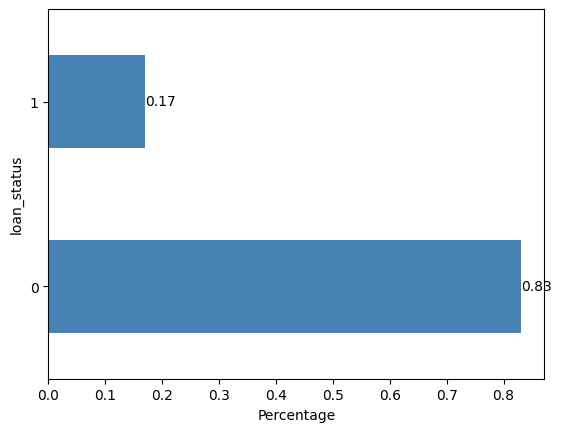

In [21]:
ax = round(train['loan_status'].value_counts(normalize=True), 2).plot(kind='barh', color='steelblue')
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.xlabel('Percentage');

In [22]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def pre_process_train(X):
    label_encoders = {}
    
    # Identify numerical columns
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    
    # Scale all numerical columns at once
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    
    # Encode categorical columns
    for col in X.select_dtypes(include=['object']).columns:
        #le = LabelEncoder()
        #X[col] = le.fit_transform(X[col])
        #label_encoders[col] = le  # Store the label encoders for future use
        X[col] = X[col].astype('category')
    
    return X, scaler, label_encoders

def pre_process_test(X_test, scaler, label_encoders):
    # Ensure the test set has the same columns in the same order as the train set
    #X_test = X_test.reindex(columns=X_train_columns, fill_value=0)
    
    # Identify numerical columns
    numerical_cols = X_test.select_dtypes(include=['int64', 'float64']).columns
    
    # Scale all numerical columns using the previously fitted scaler
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
    
    # Encode categorical columns using the previously fitted label encoders
    for col in X_test.select_dtypes(include=['object']).columns:
        #if col in label_encoders:  # Ensure that the column was encoded in training
            #le = label_encoders[col]
            #X_test[col] = le.transform(X_test[col])
        X_test[col] = X_test[col].astype('category')
    
    return X_test



In [23]:
ids= test['id']
X = train.drop(columns=['loan_status'], axis=1)
y = train.loan_status
# Pre-process the training data
X, scaler, label_encoders = pre_process_train(X)
# Pre-process the test data using the scaler and label encoders from training
test = test.drop('id', axis=1)
test = pre_process_test(test, scaler, label_encoders)


In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91061 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   person_age                     91061 non-null  float64 
 1   person_income                  91061 non-null  float64 
 2   person_home_ownership          91061 non-null  category
 3   person_emp_length              91061 non-null  float64 
 4   loan_intent                    91061 non-null  category
 5   loan_grade                     91061 non-null  category
 6   loan_amnt                      91061 non-null  float64 
 7   loan_int_rate                  91061 non-null  float64 
 8   loan_percent_income            91061 non-null  float64 
 9   cb_person_default_on_file      91061 non-null  category
 10  cb_person_cred_hist_length     91061 non-null  float64 
 11  person_income_loan_amnt_ratio  91061 non-null  float64 
dtypes: category(4), float64(8)
memory usa

In [25]:
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

In [26]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = ['f1',  'roc_auc', 'average_precision', 'precision', 'recall', 'jaccard']

# Initialize XGBoost classifier
xgb_model = XGBClassifier(enable_categorical = True)
# Perform cross-validation
xgb_cv_scores = cross_validate(xgb_model, X, y, cv=skf, scoring=scores)

# Print the cross-validation accuracy scores
for score in scores:
    print(f"XGBoost CV {score} Scores: {xgb_cv_scores['test_' + score]}")
    print(f"XGBoost Mean CV {score}: {xgb_cv_scores['test_' + score].mean()}")

XGBoost CV f1 Scores: [0.82186821 0.82028986 0.82797253 0.8358209  0.82052205]
XGBoost Mean CV f1: 0.8252947095341527
XGBoost CV roc_auc Scores: [0.95342837 0.95451716 0.95575696 0.96000165 0.95593412]
XGBoost Mean CV roc_auc: 0.9559276510906646
XGBoost CV average_precision Scores: [0.88687705 0.88928256 0.89385873 0.89722224 0.89246264]
XGBoost Mean CV average_precision: 0.8919406439939375
XGBoost CV precision Scores: [0.9318555  0.93053843 0.93663123 0.92598425 0.92379408]
XGBoost Mean CV precision: 0.9297606998522208
XGBoost CV recall Scores: [0.73510363 0.73339812 0.74190415 0.76165803 0.73801813]
XGBoost Mean CV recall: 0.7420164117954116
XGBoost CV jaccard Scores: [0.69760295 0.6953317  0.70644465 0.71794872 0.69566545]
XGBoost Mean CV jaccard: 0.7025986918352795


In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   person_age                     39098 non-null  float64 
 1   person_income                  39098 non-null  float64 
 2   person_home_ownership          39098 non-null  category
 3   person_emp_length              39098 non-null  float64 
 4   loan_intent                    39098 non-null  category
 5   loan_grade                     39098 non-null  category
 6   loan_amnt                      39098 non-null  float64 
 7   loan_int_rate                  39098 non-null  float64 
 8   loan_percent_income            39098 non-null  float64 
 9   cb_person_default_on_file      39098 non-null  category
 10  cb_person_cred_hist_length     39098 non-null  float64 
 11  person_income_loan_amnt_ratio  39098 non-null  float64 
dtypes: category(4), float64(8)
memor

In [28]:

xgb = XGBClassifier(enable_categorical = True) 
xgb.fit(X, y)
y_pred_xgb = xgb.predict_proba(test)[:, 1]
results_df_xgb = pd.DataFrame({
    'id': ids,
    'loan_status': y_pred_xgb
})
results_df_xgb.to_csv('baseline_sub_0_xgb.csv', index=False)

In [29]:
y_pred_xgb

array([0.9987753 , 0.02177496, 0.37859446, ..., 0.00694771, 0.25006387,
       0.969763  ], dtype=float32)

In [30]:
lgbm_m = lgb.LGBMClassifier()
lgbm_m.fit(X, y)
y_pred_xgb = lgbm_m.predict_proba(test)[:, 1]
results_df_xgb = pd.DataFrame({
    'id': ids,
    'loan_status': y_pred_xgb
})
results_df_xgb.to_csv('baseline_sub_0_lgbm.csv', index=False)

[LightGBM] [Info] Number of positive: 15439, number of negative: 75622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1207
[LightGBM] [Info] Number of data points in the train set: 91061, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169546 -> initscore=-1.588850
[LightGBM] [Info] Start training from score -1.588850


In [31]:
cb_params = {'loss_function': 'Logloss',
             'iterations': 195,
             'learning_rate': 0.09381481508561976,
             'depth': 11,
             'bagging_temperature': 0.0850640366226123,
             'l2_leaf_reg': 0,
             'grow_policy': 'Lossguide',
             'task_type': 'CPU'}

In [32]:
cat_columns = X.select_dtypes(include=['category']).columns.tolist()
train_data = cat.Pool(X, label=y, cat_features=cat_columns)
cat_m = cat.CatBoostClassifier(**cb_params)
cat_m.fit(train_data)
y_pred_xgb = cat_m.predict_proba(test)[:, 1]
results_df_xgb = pd.DataFrame({
    'id': ids,
    'loan_status': y_pred_xgb
})
results_df_xgb.to_csv('baseline_sub_0_cat.csv', index=False)

0:	learn: 0.6250101	total: 113ms	remaining: 22s
1:	learn: 0.5682407	total: 148ms	remaining: 14.2s
2:	learn: 0.5193534	total: 187ms	remaining: 12s
3:	learn: 0.4786096	total: 225ms	remaining: 10.7s
4:	learn: 0.4443646	total: 257ms	remaining: 9.76s
5:	learn: 0.4128189	total: 297ms	remaining: 9.35s
6:	learn: 0.3862379	total: 348ms	remaining: 9.36s
7:	learn: 0.3638138	total: 386ms	remaining: 9.02s
8:	learn: 0.3447791	total: 418ms	remaining: 8.64s
9:	learn: 0.3281839	total: 452ms	remaining: 8.36s
10:	learn: 0.3127702	total: 490ms	remaining: 8.19s
11:	learn: 0.2995073	total: 528ms	remaining: 8.06s
12:	learn: 0.2872861	total: 575ms	remaining: 8.04s
13:	learn: 0.2769518	total: 614ms	remaining: 7.94s
14:	learn: 0.2682757	total: 651ms	remaining: 7.81s
15:	learn: 0.2593455	total: 693ms	remaining: 7.75s
16:	learn: 0.2522134	total: 734ms	remaining: 7.68s
17:	learn: 0.2459252	total: 771ms	remaining: 7.58s
18:	learn: 0.2405912	total: 807ms	remaining: 7.48s
19:	learn: 0.2351548	total: 849ms	remaining: 

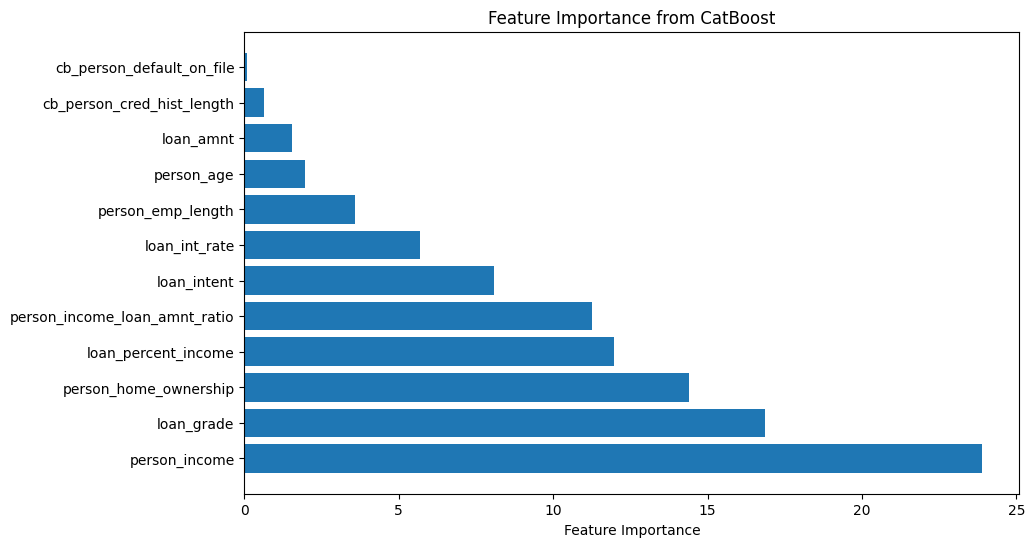

In [33]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': cat_m.get_feature_importance()
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from CatBoost')
plt.show()

In [34]:
import shap

### SHAP Values

# Convert the test data to a Pool object
#test_pool = cat.Pool(X, cat_features=cat_columns)

# Calculate SHAP values
#shap_values = cat_m.get_feature_importance(type='ShapValues', data=test_pool)

# SHAP values include the expected value as the first column, remove it for plotting
#shap_values = shap_values[:, :-1]

# Plot SHAP summary
#shap.summary_plot(shap_values, X)

# Plot SHAP force plot for an individual prediction (e.g., the first test sample)
#shap.force_plot(shap_values[0, :-1], X.iloc[0, :])